In [49]:
import sys
import pickle
import dill
import numpy as np
import pandas as pd
import html.parser
import gensim
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.initializers import Constant

In [2]:
sys.path.insert(0, '..')

%load_ext autoreload
%autoreload 2

In [4]:
from utils.text_processing import apply_regexes, unescape_html, remove_html_tags, remove_line_breaks, preprocess

In [3]:
pd.set_option('display.max_colwidth', None)

# Data Loading and Preprocessing

In [5]:
df = pd.read_csv("../data/Reviews.csv")

## Text Cleanup

In [6]:
df['cleaned_text'] = df['Text'] + ' ' + df['Summary']
df['cleaned_text'].fillna("", inplace=True)

df['cleaned_text'] = df['cleaned_text'] \
    .apply(lambda x: unescape_html(remove_html_tags(remove_line_breaks(x), 'html.parser')))

In [7]:
df['preprocessed_text'] = df['cleaned_text'].apply(preprocess)

In [8]:
df.loc[df['Score'] <= 3, 'sentiment'] = 0
df.loc[df['Score'] > 3, 'sentiment'] = 1

In [9]:
review2vec = gensim.models.Word2Vec.load("../model/review2vec.model")

## Word Embedding and Feature Engineering

In [11]:
review2vec.wv.most_similar('expired')

[('expiration', 0.8875916004180908),
 ('date', 0.8579495549201965),
 ('expires', 0.8161500096321106),
 ('expire', 0.7890604138374329),
 ('outdated', 0.7780749797821045),
 ('exp', 0.775046169757843),
 ('expiring', 0.7295963168144226),
 ('expiry', 0.7203924059867859),
 ('stale', 0.7186417579650879),
 ('oct', 0.695559024810791)]

In [18]:
review2vec.wv.similarity('taste', 'flavor')

0.81793463

In [20]:
# tokenizing the reviews words
k = 10000 # TODO: increase size

tokenizer = Tokenizer(num_words=k)
tokenizer.fit_on_texts(df['preprocessed_text'])

X = tokenizer.texts_to_sequences(df['preprocessed_text'])

# creating embedding matrix for directly feeding to Embedding() layer of Keras

num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 100)) # We trained review2vec with dim=100

for word, i in tokenizer.word_index.items():
    
    if i > num_words:
        continue
    
    if word in review2vec.wv.vocab:
        embedding_vector = review2vec.wv[word]
        embedding_matrix[i] = embedding_vector
        
# TODO: remove
# for word, i in tokenizer.word_index.items():
    
#     if i > num_words:
#         continue
        
#     embedding_vector = embeddings_index.get(word)
    
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

### Standardizing Sequence Length

*TODO*: explain why . benefit is also for SMOTE.

How to choose sequence length? 

In [29]:
num_words_per_review = df['preprocessed_text'].str.split().str.len()

Text(0.5, 1.0, 'Number of Words Per Review')

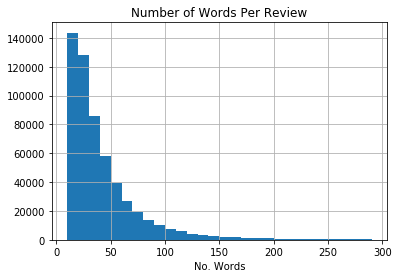

In [35]:
plt.hist(num_words_per_review, bins=[10 * i for i in range(1, 30)])
plt.grid(True)

plt.xlabel('No. Words')
plt.title('Number of Words Per Review')

In [36]:
MAX_PAD_LENGTH = 80

X = pad_sequences(X, maxlen=MAX_PAD_LENGTH, padding='post')
y = df['sentiment']

## Resampling

In [40]:
smote = SMOTE()

X_smote, y_smote = smote.fit_resample(X, y)

In [41]:
import dill

with open("../data/X_smote", 'wb') as f:
    dill.dump(X_smote, f)

with open("../data/y_smote", 'wb') as f:
    dill.dump(y_smote, f)

In [43]:
# Resampling: Train 60%, Validation 20%, Test 20%

X_train, X_valid_test, y_train, y_valid_test = train_test_split(
    X_smote, 
    y_smote, 
    test_size=0.4, 
    random_state=1, 
    stratify=y_smote
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_valid_test, 
    y_valid_test, 
    test_size=0.5, 
    random_state=1, 
    stratify=y_valid_test
)

print(f'Number of train samples: {len(X_train)}')
print(f'Number of validation samples: {len(X_valid)}')
print(f'Number of test samples: {len(X_test)}')

Number of train samples: 532532
Number of validation samples: 177511
Number of test samples: 177511


# LSTM + Word2Vec Training

In [52]:
model_review2vec = Sequential()

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'

embedding_layer = Embedding(
    num_words,
    100, # Dimension of trained review2vec
    embeddings_initializer=Constant(embedding_matrix),
    input_length=MAX_PAD_LENGTH,
    trainable=False
)
model_review2vec.add(embedding_layer)
model_review2vec.add(Dropout(0.2))

model_review2vec.add(Conv1D(64, 5, activation='relu'))
model_review2vec.add(MaxPooling1D(pool_size=4))

model_review2vec.add(LSTM(100))
model_review2vec.add(Dropout(0.4))

model_review2vec.add(Dense(1, activation='sigmoid'))

model_review2vec.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_review2vec.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 80, 100)           10437600  
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 64)            32064     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [53]:
model_review2vec_history = model_review2vec.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=10, 
    validation_data=(X_valid, y_valid)
)

Train on 532532 samples, validate on 177511 samples
Epoch 1/10
532532/532532 [==============================] - 624s 1ms/step - loss: 0.2772 - accuracy: 0.8815 - val_loss: 0.2137 - val_accuracy: 0.9118
Epoch 2/10
532532/532532 [==============================] - 621s 1ms/step - loss: 0.2205 - accuracy: 0.9085 - val_loss: 0.1950 - val_accuracy: 0.9218
Epoch 3/10
532532/532532 [==============================] - 621s 1ms/step - loss: 0.2015 - accuracy: 0.9173 - val_loss: 0.1782 - val_accuracy: 0.9281
Epoch 4/10
532532/532532 [==============================] - 621s 1ms/step - loss: 0.1902 - accuracy: 0.9223 - val_loss: 0.1793 - val_accuracy: 0.9272
Epoch 5/10
532532/532532 [==============================] - 621s 1ms/step - loss: 0.1816 - accuracy: 0.9266 - val_loss: 0.1730 - val_accuracy: 0.9316
Epoch 6/10
532532/532532 [==============================] - 623s 1ms/step - loss: 0.1764 - accuracy: 0.9287 - val_loss: 0.1705 - val_accuracy: 0.9331
Epoch 7/10
532532/532532 [======================

In [58]:
with open("../model/lstm_review2vec_history.pkl", 'wb') as f:
    dill.dump(model_review2vec_history, f)

In [67]:
with open("../model/lstm_review2vec.pkl", 'wb') as f:
    dill.dump(model_review2vec, f)

In [59]:
with open("../model/lstm_review2vec_history.pkl", 'rb') as f:
    test_history = dill.load(f)

In [62]:
val_accuracy = model_review2vec_history.history['val_accuracy']
val_loss = model_review2vec_history.history['val_loss']

train_accuracy = model_review2vec_history.history['accuracy']
train_loss = model_review2vec_history.history['loss']

epochs = range(1, len(train_accuracy) + 1)

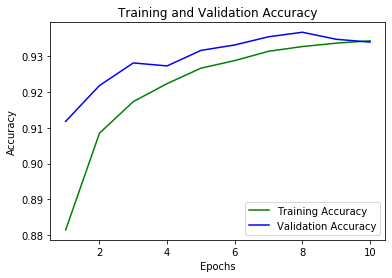

In [63]:
plt.plot(epochs, train_accuracy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

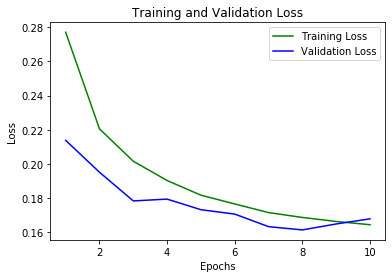

In [66]:
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [64]:
model_review2vec.evaluate(X_test, y_test)

177511/177511 [==============================] - 24s 137us/step


[0.1674115820749521, 0.9339928030967712]

# LSTM + Custom Word Embedding

In [74]:
model_custom = Sequential()

adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)
loss = 'binary_crossentropy'

embedding_layer_custom = Embedding(
    num_words,
    100,
    input_length=MAX_PAD_LENGTH
)
model_custom.add(embedding_layer_custom)
model_custom.add(Dropout(0.2))

model_custom.add(Conv1D(64, 5, activation='relu'))
model_custom.add(MaxPooling1D(pool_size=4))

model_custom.add(LSTM(100))
model_custom.add(Dropout(0.4))

model_custom.add(Dense(1, activation='sigmoid'))

model_custom.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
model_custom.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 80, 100)           10437600  
_________________________________________________________________
dropout_8 (Dropout)          (None, 80, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 64)            32064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)               

In [ ]:
model_custom_history = model_custom.fit(
    X_train, y_train, batch_size=32, 
    epochs=10, validation_data=(X_valid, y_valid))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 532532 samples, validate on 177511 samples
Epoch 1/10
532532/532532 [==============================] - 650s 1ms/step - loss: 0.2566 - accuracy: 0.8947 - val_loss: 0.1805 - val_accuracy: 0.9313
Epoch 2/10
532532/532532 [==============================] - 649s 1ms/step - loss: 0.1584 - accuracy: 0.9407 - val_loss: 0.1628 - val_accuracy: 0.9396
Epoch 3/10
532532/532532 [==============================] - 650s 1ms/step - loss: 0.1253 - accuracy: 0.9537 - val_loss: 0.1575 - val_accuracy: 0.9421
Epoch 4/10
532532/532532 [==============================] - 647s 1ms/step - loss: 0.1063 - accuracy: 0.9613 - val_loss: 0.1625 - val_accuracy: 0.9429
Epoch 5/10
532532/532532 [==============================] - 646s 1ms/step - loss: 0.0931 - accuracy: 0.9662 - val_loss: 0.1724 - val_accuracy: 0.9432
Epoch 6/10
532532/532532 [==============================] - 647s 1ms/step - loss: 0.0839 - accuracy: 0.9697 - val_loss: 0.1896 - val_accuracy: 0.9399
Epoch 7/10
532532/532532 [======================

In [ ]:
with open("../model/lstm_custom.pkl", 'wb') as f:
    dill.dump(model_custom, f)

In [81]:
with open("../model/lstm_custom_history.pkl", 'wb') as f:
    dill.dump(model_custom_history, f)

In [78]:
val_accuracy_custom = model_custom_history.history['val_accuracy']
val_loss_custom = model_custom_history.history['val_loss']

train_accuracy_custom = model_custom_history.history['accuracy']
train_loss_custom = model_custom_history.history['loss']

epochs_custom = range(1, len(train_accuracy_custom) + 1)

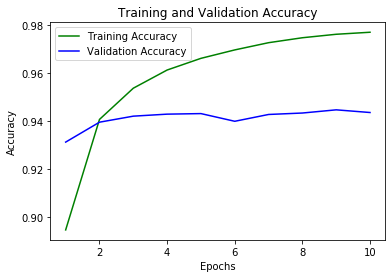

In [79]:
plt.plot(epochs_custom, train_accuracy_custom, 'g', label='Training Accuracy')
plt.plot(epochs_custom, val_accuracy_custom, 'b', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

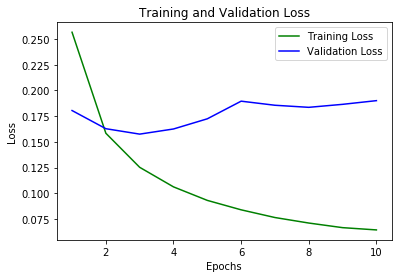

In [80]:
plt.plot(epochs, train_loss_custom, 'g', label='Training Loss')
plt.plot(epochs, val_loss_custom, 'b', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [77]:
model_custom.evaluate(X_test, y_test)

177511/177511 [==============================] - 24s 137us/step


[0.19211047443615542, 0.9431697130203247]